# PatchCore

In [1]:
import common
import sampler
import patchcore
import backbones
import utils

c:\Users\qlee\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from PIL import Image
from torchvision import transforms

import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from argparse import ArgumentParser

parser = ArgumentParser(description="patchcore")
parser.add_argument('--image_size', default=224, type=int) # 224
parser.add_argument('--resize', default=256, type=int) # 256
parser.add_argument('--backbone', default='wideresnet50', type=str) 
parser.add_argument('--layers_to_extract_from', nargs='+', default=['layer2', 'layer3'], type=str) # 연산량에 큰 영향을 주는 파라미터터
parser.add_argument('--pretrain_embed_dimension', default=1024, type=int)
parser.add_argument('--target_embed_dimension', default=1024, type=int)
parser.add_argument('--patchsize', default=3, type=int)
parser.add_argument('--coreset_rate', default=0.1, type=float) # 연산량에 큰 영향을 주는 파라미터터
parser.add_argument('--anomaly_scorer_num_nn', default=1, type=int)
parser.add_argument('--batch_size', default=2, type=int)
parser.add_argument('--batch_size_inf', default=6, type=int)
parser.add_argument('--augment', default=True, type=bool)
parser.add_argument('--seed', default=0, type=int) 
parser.add_argument('--device', nargs='+', default=[0], type=int)
parser.add_argument('--num_workers', default=0, type=int)
args = parser.parse_args('')

image_size = args.image_size
resize = args.resize
BATCH_SIZE = args.batch_size
BATCH_SIZE_INF = args.batch_size_inf
SEED = args.seed

# create save path
save_root = "saved"
if not os.path.exists(save_root):
    os.mkdir(save_root)

def set_seeds(seed=SEED):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    pl.seed_everything(SEED)

set_seeds()

Seed set to 0


## data loader

In [3]:
class AnomalyDataset(Dataset):
    def __init__(self, transform=None, dir="../Data/mvtec/screw/train/good", test=False):
        super().__init__()
        self.test = test        
        self.transform = transform
        self.list_dir = sorted(glob.glob(os.path.join(dir, "*.png")))
        self.list_data = []
        if test: self.list_original_data = []

        for idx, dir in enumerate(self.list_dir):
            x = Image.open(dir).convert("RGB")
            if test: self.list_original_data.append(x)
            if self.transform: x = self.transform(x)
            self.list_data.append(x)
        
        print(f"num_data: {len(self.list_data)}")

    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self, idx):
        x = self.list_data[idx]
        return {"image": x}

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
train_dataset = AnomalyDataset(dir="../Data/mvtec/screw/train/good", transform=train_transform)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=args.num_workers,
                              pin_memory=True)

valid_dataset = AnomalyDataset(dir="../Data/mvtec/screw/test/good", transform=test_transform)
valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=args.num_workers,
                              pin_memory=True)

num_data: 320
num_data: 41


## train

In [6]:
device = utils.set_torch_device(gpu_ids=args.device)
patch_core = patchcore.PatchCore(device)

patch_core.load(
    backbone                 = args.backbone,
    layers_to_extract_from   = args.layers_to_extract_from,
    device                   = device,
    input_shape              = (3, image_size, image_size),
    pretrain_embed_dimension = args.pretrain_embed_dimension,
    target_embed_dimension   = args.target_embed_dimension,
    patchsize                = args.patchsize,
    anomaly_scorer_num_nn    = args.anomaly_scorer_num_nn,
    featuresampler           = sampler.ApproximateGreedyCoresetSampler(percentage=args.coreset_rate, device=device),
    nn_method                = common.FaissNN(on_gpu=True, num_workers=8)
)

In [7]:
# train
patch_core.fit(train_dataloader)

# save model
patch_core.save_to_path(save_path=save_root)

Subsampling...: 100%|██████████| 627/627 [00:00<00:00, 2866.14it/s]


In [8]:
# load model
patch_core.load_from_path(load_path=save_root, 
                          device=device, 
                          nn_method=common.FaissNN(on_gpu=True, num_workers=8))

# validate for threshold
scores, _ = patch_core.predict(valid_dataloader)

threshold = np.max(scores)
print(f"threshold: {threshold}")

threshold: 2.9198169708251953


## inference

In [9]:
# screw: manipulated_front | scratch_head | scratch_neck | thread_side | thread_top
# bottle: broken_large | broken_small | contamination
# metal_nut: bent | color | flip | scratch
test_dataset = AnomalyDataset(dir="../Data/mvtec/screw/test/manipulated_front", transform=test_transform, test=True)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE_INF, 
                             shuffle=False, 
                             num_workers=args.num_workers,
                             pin_memory=True)

threshold_list = [] 
scores_list = []
seg_list = []

# inference
start = time.time()
scores, seg = patch_core.predict(test_dataloader)
print(f"Avg Prediction Time: {(time.time() - start) / (len(test_dataloader) * BATCH_SIZE_INF) :.6f}")

threshold_list.append(threshold)
scores_list.append(scores)
seg_list.append(seg)

num_data: 24


Avg Prediction Time: 0.017712


In [10]:
threshold = np.mean(threshold_list)
print(f"threshold: {threshold}")

scores = np.max(scores_list, axis=0)
prediction = np.where(scores<threshold, 0, 1)

print(f"n_anomaly: {np.sum(prediction)}")

threshold: 2.9198169708251953
n_anomaly: 5


In [11]:
# scores = np.array(scores_list)
# min_scores = scores.min(axis=-1).reshape(-1, 1)
# max_scores = scores.max(axis=-1).reshape(-1, 1)
# scores = (scores - min_scores) / (max_scores - min_scores)
# scores = np.mean(scores, axis=0)

segmentations = np.array(seg_list)
min_scores = (segmentations.reshape(len(segmentations), -1).min(axis=-1).reshape(-1, 1, 1, 1))
max_scores = (segmentations.reshape(len(segmentations), -1).max(axis=-1).reshape(-1, 1, 1, 1))
segmentations = (segmentations - min_scores) / (max_scores - min_scores)
segmentations = np.mean(segmentations, axis=0)

# imgs = [np.transpose(x, (1, 2, 0)) for x in test_dataset.list_original_data]
imgs = [x for x in test_dataset.list_original_data]

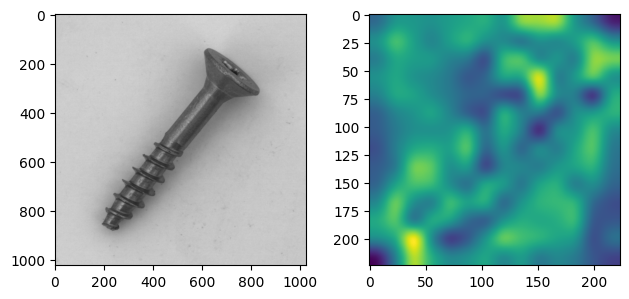

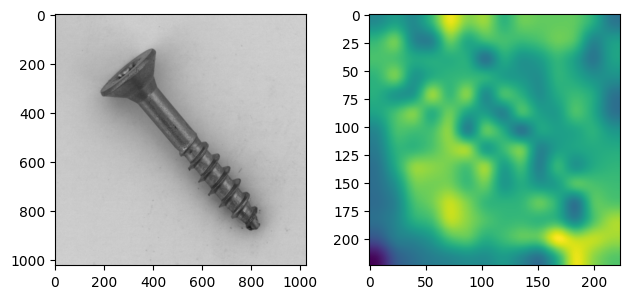

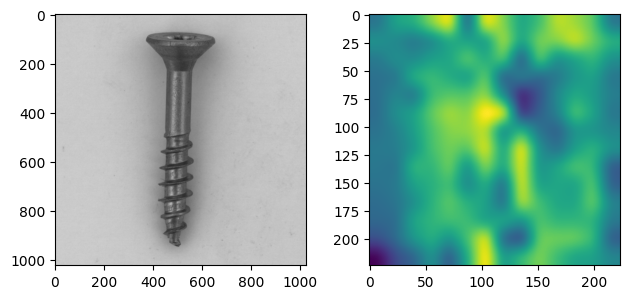

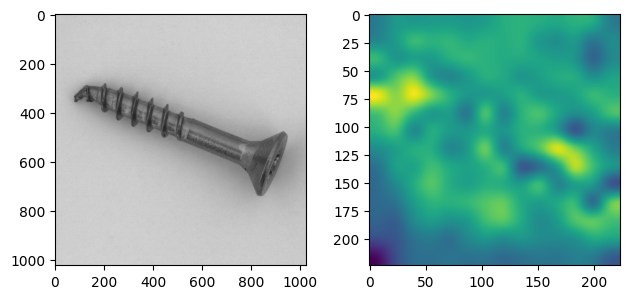

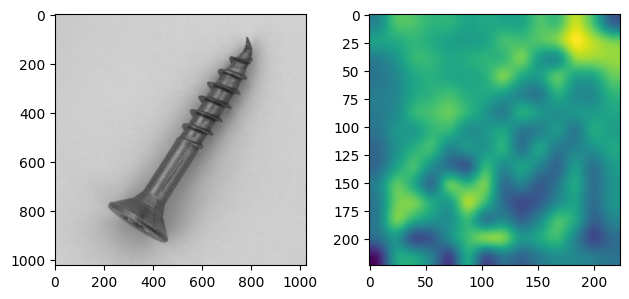

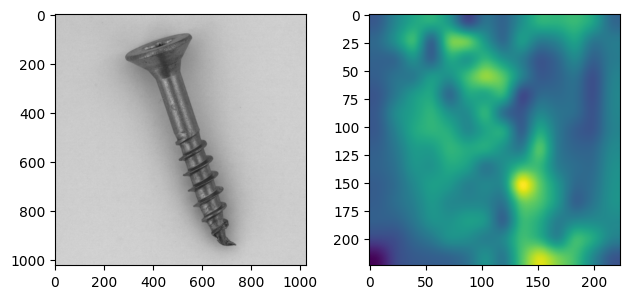

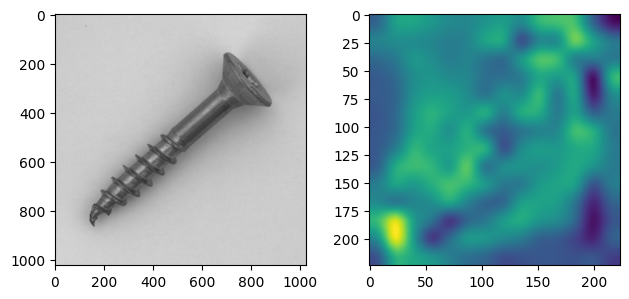

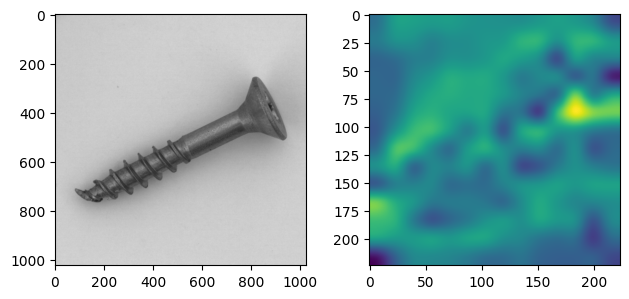

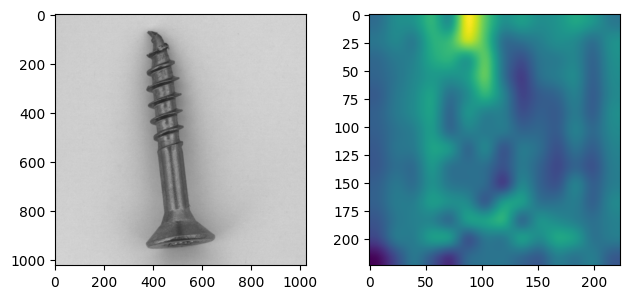

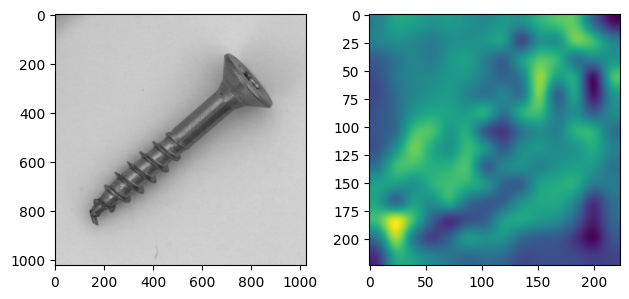

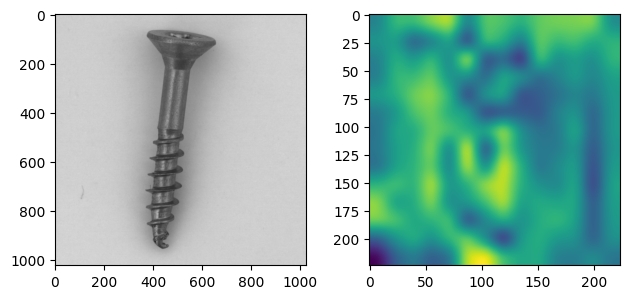

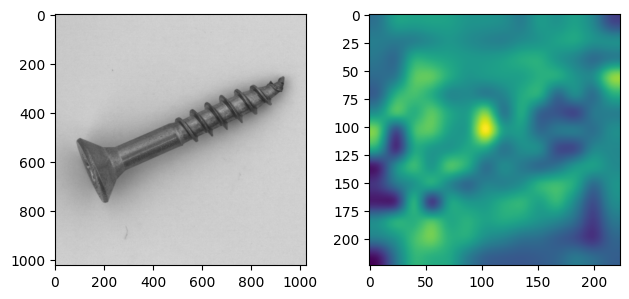

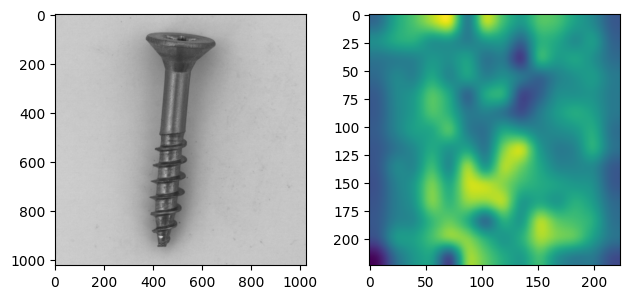

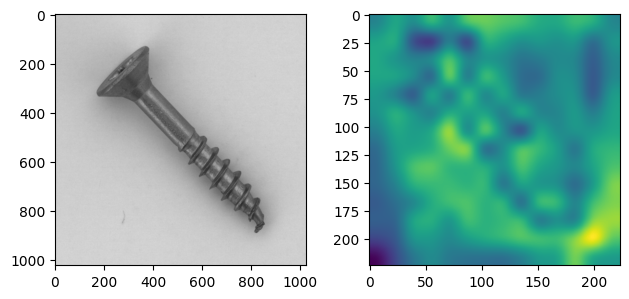

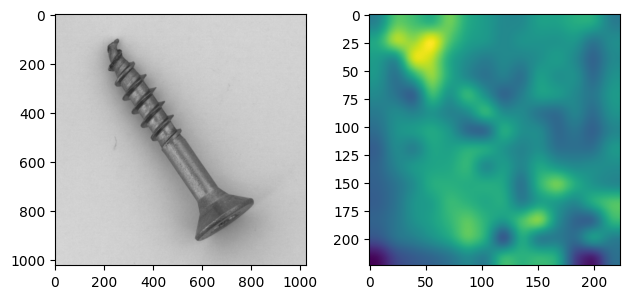

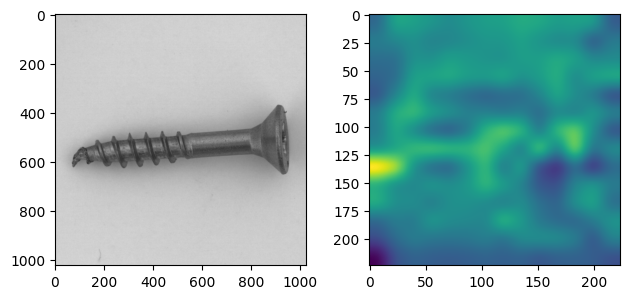

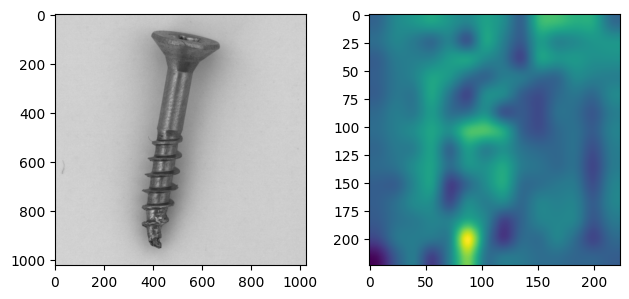

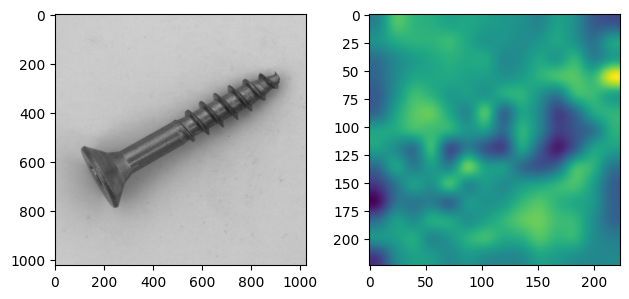

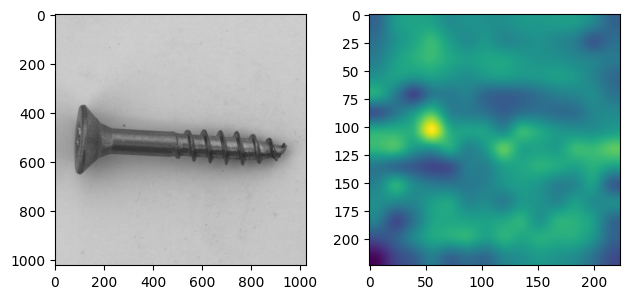

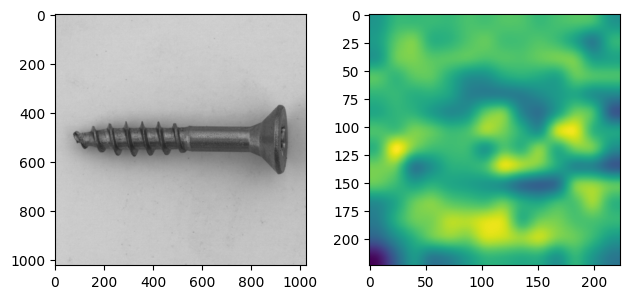

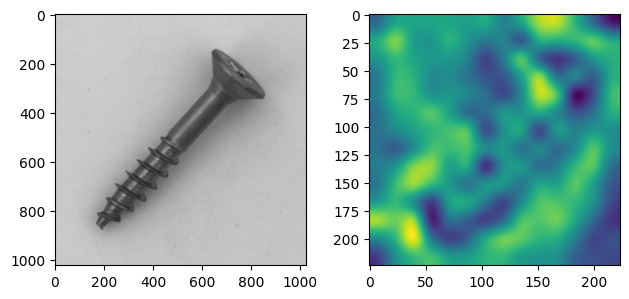

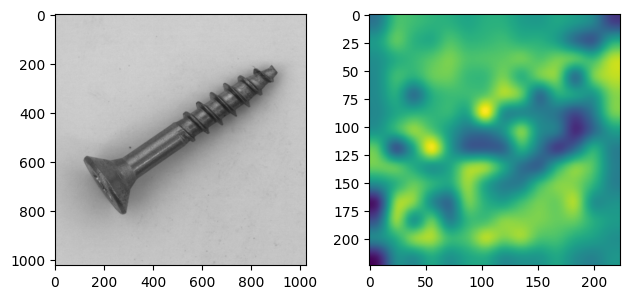

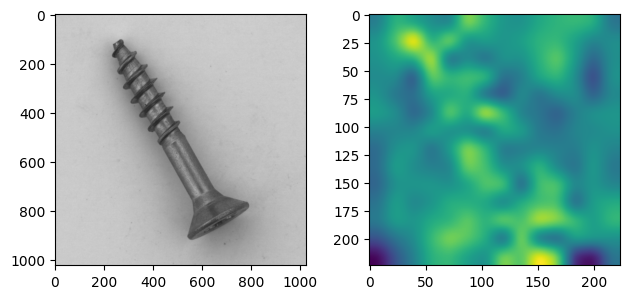

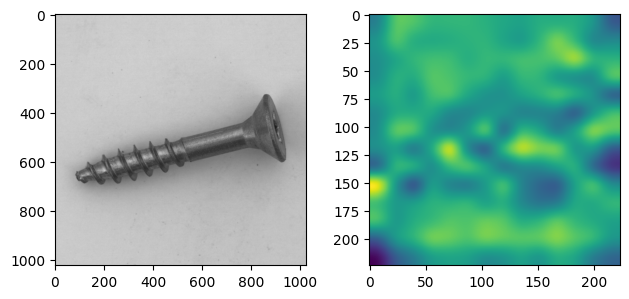

In [12]:
for idx in range(len(imgs)):
    f, axes = plt.subplots(1, 2)
    axes[0].imshow(imgs[idx])
    axes[1].imshow(segmentations[idx])
    f.tight_layout()